# Fraud Detection
In this tutorial, we demonstrate how to use the classification capablity of EvaDB to detect fraud.
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/16-homesale-forecasting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/cs1234500000/evadb/blob/staging/tutorials/16-homesale-forecasting.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/16-homesale-forecasting.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

## Setup
We first setup the backend postgres database and EvaDB to bring AI inside database systems.

### Install and Launch the PostgreSQL Server

In [1]:
!apt -qq install postgresql
!service postgresql start

The following additional packages will be installed:
  libcommon-sense-perl libjson-perl libjson-xs-perl libtypes-serialiser-perl logrotate netbase
  postgresql-14 postgresql-client-14 postgresql-client-common postgresql-common ssl-cert sysstat
Suggested packages:
  bsd-mailx | mailx postgresql-doc postgresql-doc-14 isag
The following NEW packages will be installed:
  libcommon-sense-perl libjson-perl libjson-xs-perl libtypes-serialiser-perl logrotate netbase
  postgresql postgresql-14 postgresql-client-14 postgresql-client-common postgresql-common ssl-cert
  sysstat
0 upgraded, 13 newly installed, 0 to remove and 18 not upgraded.
Need to get 18.3 MB of archives.
After this operation, 51.5 MB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package logrotate.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1

### Create User and Database

In [2]:
!sudo -u postgres psql -c "CREATE USER eva WITH SUPERUSER PASSWORD 'password'"
!sudo -u postgres psql -c "CREATE DATABASE evadb"

CREATE ROLE
CREATE DATABASE


###Prettify  Output

In [3]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace("\\n","<br>")))

### Install EvaDB

We install EvaDB with extra postgres and forecasting dependency.

In [4]:
%pip install --quiet "evadb[postgres,ludwig]"

import evadb
cursor = evadb.connect().cursor()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.1/530.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 871kB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## Prepare Data
We then prepara the dataset used in this fraud detection use case.

### Create Data Source in EvaDB
We use data source to connect EvaDB directly to underlying database systems like Postgres.

In [5]:
params = {
    "user": "eva",
    "password": "password",
    "host": "localhost",
    "port": "5432",
    "database": "evadb",
}
query = f"CREATE DATABASE postgres_data WITH ENGINE = 'postgres', PARAMETERS = {params};"
cursor.query(query).df()

,0
0,The database postgres_data has been successful...


### Load the Datasets
We load the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/shubhamjoshi2130of/abstract-data-set-for-credit-card-fraud-detection?resource=download) into our PostgreSQL database.

This command will download the credit card fraud dataset from Kaggle after data cleaning.
The creditcard_fraud dataset contains over 3K records with 11 features and a binary label indicating whether a transaction was fraudulent or not.

In [6]:
!mkdir -p content
!wget -qnc -O /content/creditcard_fraud.csv https://www.dropbox.com/scl/fi/fhaqbg3la10g7wkr38wtx/creditcard.csv?rlkey=vwc69xhn8845cqhykuplbrdok&dl=0

In [7]:
cursor.query("""
  USE postgres_data {
    CREATE TABLE IF NOT EXISTS creditcard_fraud (
      merchant_id VARCHAR(64),
      avg_amount FLOAT,
      transaction_amount FLOAT,
      is_declined INTEGER,
      total_declines INTEGER,
      is_foreign INTEGER,
      is_high_risk_country INTEGER,
      daily_chargeback_avg_amt FLOAT,
      six_month_avg_chbk_amt FLOAT,
      six_month_chbk_freq INTEGER,
      is_fraudulent INTEGER
    )
  }
""").df()

,status
0,success


In [8]:
cursor.query("""
  USE postgres_data {
    COPY creditcard_fraud
    FROM '/content/creditcard_fraud.csv'
    DELIMITER ',' CSV HEADER
  }
""").df()

,status
0,success


### Preview the Data
The `creditcard_fraud` table contains 11 columns.
- merchant_id: merchant ID
- avg_amount: average amount/transaction/day
- transaction_amount: transaction amount
- is_declined: is declined(1) or not(0)
- total_declines: total number of declines/day
- is_foreign: is foreign(1) or not(0)
- is_high_risk_country: is high risk country(1) or not(0)
- daily_chargeback_avg_amt: daily chargeback average amount
- six_month_avg_chbk_amt: six month average chargeback average amount
- six_month_chbk_freq: six month chargeback frequency
- is_fraudulent: is fraudulent(1) or not(0)

In [14]:
cursor.query("SELECT * FROM postgres_data.creditcard_fraud LIMIT 5").df()

,creditcard_fraud.is_fraudulent,creditcard_fraud.avg_amount,creditcard_fraud.transaction_amount,creditcard_fraud.is_declined,creditcard_fraud.total_declines,creditcard_fraud.is_foreign,creditcard_fraud.is_high_risk_country,creditcard_fraud.daily_chargeback_avg_amt,creditcard_fraud.six_month_avg_chbk_amt,creditcard_fraud.six_month_chbk_freq,creditcard_fraud.merchant_id
0,1,100.0,3000.0,0,5,1,1,0.0,0.0,0,3160040998
1,1,100.0,4300.0,0,5,1,1,0.0,0.0,0,3160040998
2,1,185.5,4823.0,1,5,0,0,0.0,0.0,0,3160041896
3,1,185.5,5008.5,1,8,0,0,0.0,0.0,0,3160141996
4,1,500.0,26000.0,0,0,1,1,800.0,677.2,6,3160241992


## Data Analysis with EvaDB

In [10]:
cursor.query("""
  SELECT AVG(avg_amount), AVG(six_month_avg_chbk_amt)
  FROM postgres_data.creditcard_fraud
  WHERE is_fraudulent = 0;
"""
).df()

,AVG.avg_amount,AVG.six_month_avg_chbk_amt
0,512.19369,15.824134


In [11]:
cursor.query("""
  SELECT AVG(avg_amount), AVG(six_month_avg_chbk_amt)
  FROM postgres_data.creditcard_fraud
  WHERE is_fraudulent = 1;
"""
).df()

,AVG.avg_amount,AVG.six_month_avg_chbk_amt
0,531.638032,181.917187


## Model Training with EvaDB

We then use EvaDB to train a model to detect credit card frauds.

### Train the Classification Model
For this purpose, we harness the capabilities of the **ludwig** engine to train our classificationon model. We employ the automl feature to automatically determine the optimal hyperparameters. Keep in mind that TIME_LIMIT specifies the time budget allocated for the training process.

In [15]:
cursor.query("""
  CREATE OR REPLACE FUNCTION CreditCardFraudDetection FROM
  (SELECT * FROM postgres_data.creditcard_fraud)
  TYPE Ludwig
  Predict 'is_fraudulent'
  TIME_LIMIT 3600;
""").df()

/usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


Analyzing fields: 100%|██████████| 11/11 [00:00<00:00, 370.79it/s]
2023-10-17 12:32:59,958	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(_register pid=7216) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(_register pid=7216)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(_register pid=7216) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(_register pid=7216) Created a temporary directory at /tmp/tmpl4k0zjlb
(_register pid=7216) Writing /tmp/tmpl4k0zjlb/_remote_module_non_scriptable.py


(_register pid=7216) 2023-10-17 12:33:23.304009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(_register pid=7216) /usr/local/lib/python3.10/dist-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:
(_register pid=7216) 
(_register pid=7216) from ray.air import session
(_register pid=7216) 
(_register pid=7216) def train(config):
(_register pid=7216)     # ...
(_register pid=7216)     session.report({"metric": metric}, checkpoint=checkpoint)
(_register pid=7216) 
(_register pid=7216) For more information please see https://docs.ray.io/en/latest/tune/api/trainable.html
(_register pid=7216) 
(_register pid=7216)   warnings.warn(


(pid=7422) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(pid=7422) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=7422)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=7422) Created a temporary directory at /tmp/tmpm2_qk_j3
(pid=7422) Writing /tmp/tmpm2_qk_j3/_remote_module_non_scriptable.py


(pid=7422) 2023-10-17 12:33:43.709122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=7422) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=7422)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
(pid=7548) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=7548)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=7548) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(pid=7548) Created a temporary directory at /tmp/tmp0l9rx458
(pid=7548) Writing /tmp/tmp0l9rx458/_remote_module_non_scriptable.py


(pid=7548) 2023-10-17 12:34:16.000164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(run_experiment_trial pid=7548) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=7548)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
(pid=8113) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=8113)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=8113) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(pid=8113) Created a temporary directory at /tmp/tmpz3bbdhci
(pid=8113) Writing /tmp/tmpz3bbdhci/_remote_module_non_scriptable.py


(pid=8113) 2023-10-17 12:35:53.257572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=8113) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=8113)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")


(pid=8638) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(pid=8638) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=8638)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=8638) Created a temporary directory at /tmp/tmpd7uikene
(pid=8638) Writing /tmp/tmpd7uikene/_remote_module_non_scriptable.py


(pid=8638) 2023-10-17 12:37:28.724260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=8638) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=8638)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")


(pid=8869) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(pid=8869) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=8869)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=8869) Created a temporary directory at /tmp/tmpwc1y3k62
(pid=8869) Writing /tmp/tmpwc1y3k62/_remote_module_non_scriptable.py


(pid=8869) 2023-10-17 12:38:12.662336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=8869) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=8869)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
(pid=9161) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=9161)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=9161) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(pid=9161) Created a temporary directory at /tmp/tmpic7oxlhy
(pid=9161) Writing /tmp/tmpic7oxlhy/_remote_module_non_scriptable.py


(pid=9161) 2023-10-17 12:39:03.350205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=9161) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=9161)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")


(pid=9398) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(pid=9398) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=9398)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=9398) Created a temporary directory at /tmp/tmp843rpspq
(pid=9398) Writing /tmp/tmp843rpspq/_remote_module_non_scriptable.py


(pid=9398) 2023-10-17 12:39:48.686975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=9398) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=9398)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
(pid=9686) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=9686)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=9686) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(pid=9686) Created a temporary directory at /tmp/tmpxprx2jxo
(pid=9686) Writing /tmp/tmpxprx2jxo/_remote_module_non_scriptable.py


(pid=9686) 2023-10-17 12:40:37.719953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=9686) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=9686)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
(pid=9934) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=9934)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=9934) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
(pid=9934) Created a temporary directory at /tmp/tmpk28d1lwe
(pid=9934) Writing /tmp/tmpk28d1lwe/_remote_module_non_scriptable.py


(pid=9934) 2023-10-17 12:41:23.833447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-17 12:41:36,590	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.566 s, which may be a performance bottleneck.
2023-10-17 12:41:36,602	WARNING util.py:244 -- The `process_trial_result` operation took 0.580 s, which may be a performance bottleneck.
2023-10-17 12:41:36,608	WARNING util.py:244 -- Processing trial results took 0.585 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-10-17 12:41:36,610	WARNING util.py:244 -- The `process_trial_result` operation took 0.587 s, which may be a performance bottleneck.
(run_experiment_trial pid=9934) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=9934)   warnings.warn("

(pid=10205) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(pid=10205) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(pid=10205)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(pid=10205) Created a temporary directory at /tmp/tmph5opwmsb
(pid=10205) Writing /tmp/tmph5opwmsb/_remote_module_non_scriptable.py


(pid=10205) 2023-10-17 12:42:15.453278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(run_experiment_trial pid=10205) /usr/local/lib/python3.10/dist-packages/ludwig/schema/model_types/utils.py:242: UserWarning: Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.
(run_experiment_trial pid=10205)   warnings.warn("Can't utilize `early_stop` while using a hyperopt scheduler. Setting early stop to -1.")
2023-10-17 12:43:26,865	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.681 s, which may be a performance bottleneck.
2023-10-17 12:43:26,874	WARNING util.py:244 -- The `process_trial_result` operation took 0.690 s, which may be a performance bottleneck.
2023-10-17 12:43:26,883	WARNING util.py:244 -- Processing trial results took 0.698 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-10-17 12:43:26,887	WARNING util.py:244 -

,0
0,Function CreditCardFraudDetection added to the...


### Employ the Classification Model

Following the model training, we proceed to employ the `CreditCardFraudDetection` model to make predictions for credit card frauds.

In [16]:
cursor.query("""
  SELECT CreditCardFraudDetection(*) FROM postgres_data.creditcard_fraud LIMIT 10;
  """
).df()

(dask:('normalize-ec8cf085515cddd6ca694dc33d325a6d', 0) pid=11479) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(dask:('normalize-ec8cf085515cddd6ca694dc33d325a6d', 0) pid=11479)   warn("The installed version of bitsandbytes was compiled without GPU support. "


(dask:('normalize-ec8cf085515cddd6ca694dc33d325a6d', 0) pid=11479) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


2023-10-17 12:46:27,913	INFO streaming_executor.py:83 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(BatchInferModel)]
2023-10-17 12:46:27,920	INFO streaming_executor.py:84 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-17 12:46:28,011	INFO actor_pool_map_operator.py:99 -- MapBatches(BatchInferModel): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapWorker(MapBatches(BatchInferModel)) pid=11604) Created a temporary directory at /tmp/tmpm1yfsz1r
(MapWorker(MapBatches(BatchInferModel)) pid=11604) Writing /tmp/tmpm1yfsz1r/_remote_module_non_scriptable.py
(MapWorker(MapBatches(BatchInferModel)) pid=11604) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(MapWorker(MapBatches(BatchInferModel)) pid=11604)   warn("The installed version of bitsandbytes was compiled without GPU support. "
(MapWorker(MapBatches(BatchInferModel)) pid=11604)   warn("The installed version of bitsandbytes was compiled without GPU support. "
2023-10-17 12:46:45,616	INFO streaming_executor.py:83 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(postprocess_batch)]
2023-10-17 12:46:45,625	INFO streaming_executor.py:84 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

,creditcardfrauddetection.is_fraudulent_predictions
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


We have the option to utilize a `LATERAL JOIN` to compare the actual fraud in the creditcard_fraud dataset with the predicted fraud generated by the trained model, CreditCardFraudDetection.

In [33]:
df = cursor.query("""
  SELECT is_fraudulent, is_fraudulent_predictions
  FROM postgres_data.creditcard_fraud
  JOIN LATERAL CreditCardFraudDetection(*) AS Predicted(is_fraudulent_predictions);
""").df()
df

2023-10-17 12:57:06,840	INFO streaming_executor.py:83 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(BatchInferModel)]
2023-10-17 12:57:06,842	INFO streaming_executor.py:84 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-10-17 12:57:06,895	INFO actor_pool_map_operator.py:99 -- MapBatches(BatchInferModel): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapWorker(MapBatches(BatchInferModel)) pid=14685) Created a temporary directory at /tmp/tmpuqhehv45
(MapWorker(MapBatches(BatchInferModel)) pid=14685) Writing /tmp/tmpuqhehv45/_remote_module_non_scriptable.py
(MapWorker(MapBatches(BatchInferModel)) pid=14685) /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


(MapWorker(MapBatches(BatchInferModel)) pid=14685) /usr/local/lib/python3.10/dist-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
(MapWorker(MapBatches(BatchInferModel)) pid=14685)   warn("The installed version of bitsandbytes was compiled without GPU support. "
2023-10-17 12:57:29,002	INFO streaming_executor.py:83 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(postprocess_batch)]
2023-10-17 12:57:29,008	INFO streaming_executor.py:84 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

,creditcard_fraud.is_fraudulent,Predicted.is_fraudulent_predictions
0,1,True
1,1,True
2,1,True
3,1,True
4,1,True
...,...,...
3070,0,True
3071,0,False
3072,0,False
3073,0,False


## Report

In [65]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,classification_report

In [62]:
df["Predicted.is_fraudulent_predictions"] = df["Predicted.is_fraudulent_predictions"].astype(int)

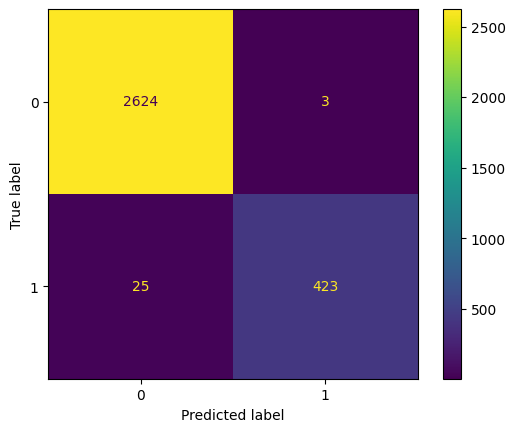

In [63]:
y_true = df.iloc[:, 0]
y_pred = df.iloc[:, 1]
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [69]:
# print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2627
           1       0.99      0.94      0.97       448

    accuracy                           0.99      3075
   macro avg       0.99      0.97      0.98      3075
weighted avg       0.99      0.99      0.99      3075

